## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_horizontal_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/horizontal/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


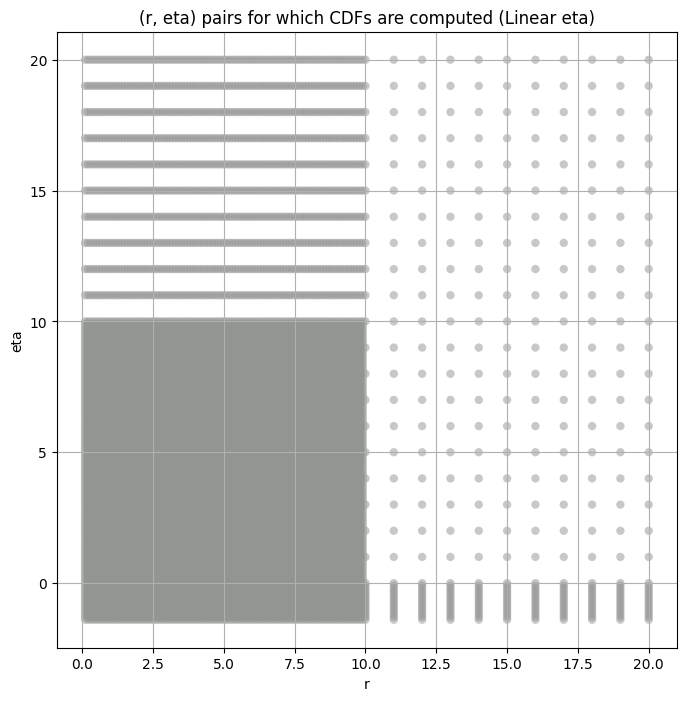

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.674777e+07  2.408478e+07  2.952804e+07   0.489990    0.057459   
3      5.682067e+06  5.344561e+06  6.025917e+06   1.473783    1.142481   
4      1.214204e+06  1.143547e+06  1.286625e+06   3.190731    2.697830   
5      2.286304e+05  2.133339e+05  2.444792e+05   5.111354    4.417289   
6      4.117562e+04  3.780443e+04  4.468856e+04   8.670665    7.367621   
7      7.078735e+03  6.389601e+03  7.818102e+03  13.188631   10.900856   
8      1.293570e+03  1.142861e+03  1.458887e+03  20.103813   15.939114   
9      2.717562e+02  2.358089e+02  3.111081e+02  27.190210   20.843605   

       kurt_upper  total_samples  
layer                             
2        0.969847           1604  
3        1.844055           6416  
4        3.727371          25664  
5        5.861666         102656  
6       10.148466         410624  
7       15.908423        1642496  
8       25.115570        6569984  
9       35.941853       26279936

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      2.674777e+07   2.674777e+07    2.136938e+07    1.843213e+07   
3      5.682067e+06   5.682067e+06    5.140449e+06    4.784766e+06   
4      1.214204e+06   1.214204e+06    1.157989e+06    1.117663e+06   
5      2.286304e+05   2.286304e+05    2.245220e+05    2.212140e+05   
6      4.117562e+04   4.117562e+04    4.010977e+04    3.927881e+04   
7      7.078735e+03   7.078735e+03    6.824425e+03    6.636746e+03   
8      1.293570e+03   1.293570e+03    1.229148e+03    1.183526e+03   
9      2.717562e+02   2.717562e+02    2.549123e+02    2.433346e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        1.616622e+07     1.428466e+07     1.117992e+07     8.764880e+06   
3        4.494450e+06     4.248130e+06     3.840138e+06     3.503724e+06   
4        1.083698e+06     1.054575e+06     1.003741e+06     9.602802e+05   
5        2.182934e+05     2.155853e+05     2.106334e+05     2.061885e+05   
6        3.854496e+04     3.787537e+04     3.668870e+04     3.564687e+04   
7        6.475491e+03     6.331187e+03     6.078205e+03     5.860109e+03   
8        1.145291e+03     1.111814e+03     1.054450e+03     1.005881e+03   
9        2.337421e+02     2.254414e+02     2.114273e+02     1.997740e+02   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         6.885890e+06     5.376104e+06     4.143833e+06     1.661313e+06  
3         3.208262e+06     2.952668e+06     2.724868e+06     2.174168e+06  
4         9.218026e+05     8.871759e+05     8.556782e+05     7.735383e+05  
5         2.021145e+05     1.983193e+05     1.947595e+05     1.852208e+05  
6         3.470696e+04     3.384525e+04     3.304823e+04     3.095429e+04  
7         5.665756e+03     5.489315e+03     5.327464e+03     4.907430e+03  
8         9.634747e+02     9.256982e+02     8.916469e+02     8.057340e+02  
9         1.897690e+02     1.810049e+02     1.732123e+02     1.539795e+02

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.08959939401287148 26747772.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.09209957828919424 21369376.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.10017068346766111 18432128.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.11294644566259826 16166225.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.12613576159021578 14284661.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.1540656223380531 11179922.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.18096952224445617 8764880.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.20907264950972437 6885890.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.23761549091269363 5376104.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.26644997031708373 4143832.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.35359772090096697 1661312.9
Number of samples: 1604, Without approximation : 1604


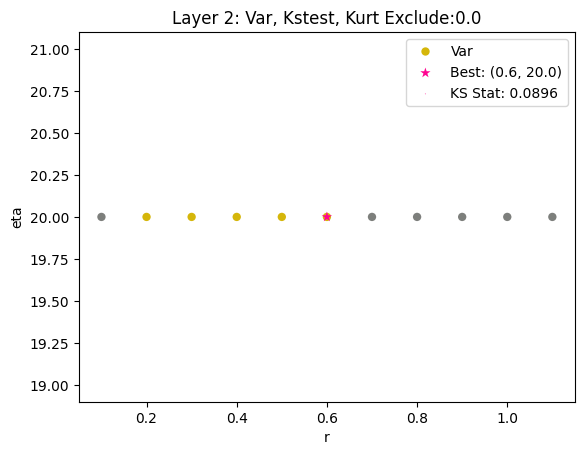

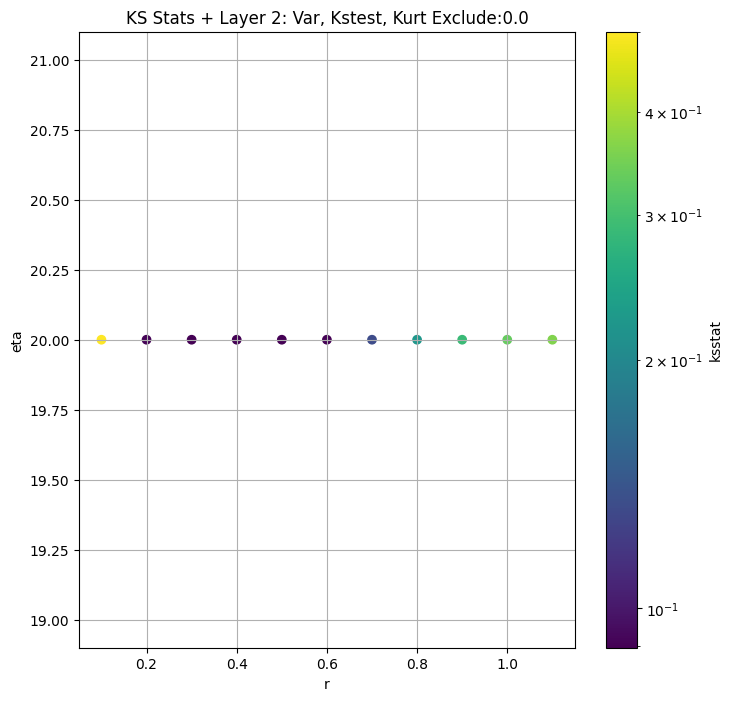

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.05460960008439797 5682067.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.05460933194604328 5140449.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.05463211722191835 4784766.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.054636425786987464 4494450.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.05464142907168851 4248130.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.054665334022455936 3840138.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.056154598047887694 3503724.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.05947735996862746 3208262.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.06734189118837519 2952667.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.07592355461640088 2724867.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.09835639908630522 2174168.2
Number of samples: 6416, Without approximation : 6416


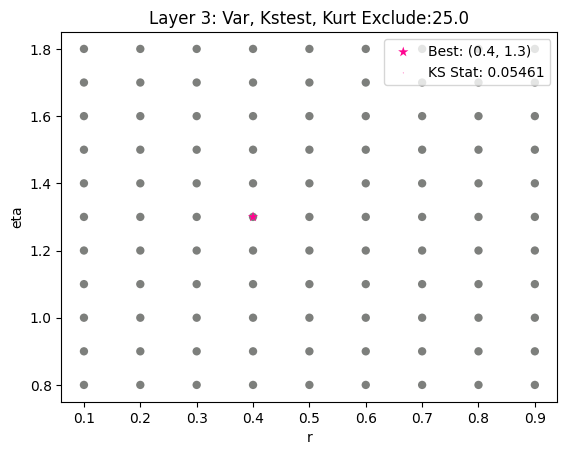

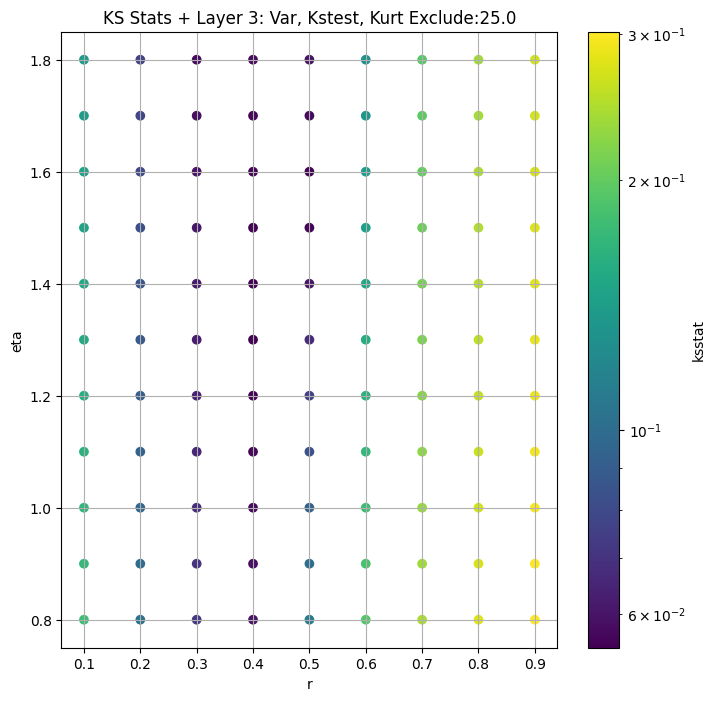

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.04359652843029588 1214204.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.04338187369508345 1157989.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.04325056434926011 1117663.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.04406654478376787 1083698.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.043731622696343175 1054575.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.04466655284488735 1003741.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.04521698376656991 960280.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.0448955912541632 921802.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.04490284770789654 887175.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.04587786165626917 855678.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.04769611830666143 773538.3
Number of samples: 25664, Without approximation : 25664


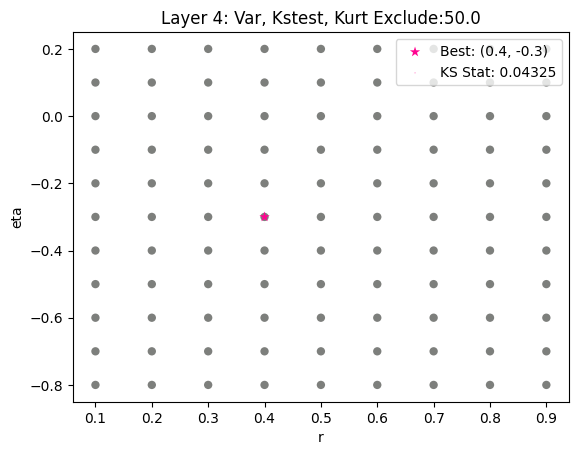

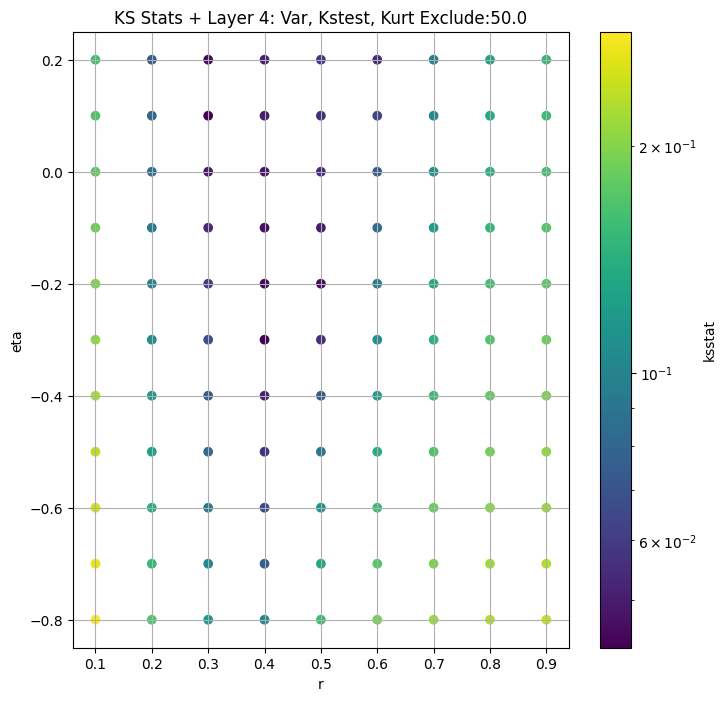

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.03290902055306344 228630.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.03302769272803047 224521.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.03269883486063957 221213.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0325143965648344 218293.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.032341620252385295 215585.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.03231742714037944 210633.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.032196116053773705 206188.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.03217424803364949 202114.55


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.032154050299983306 198319.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.03213641200455447 194759.55


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03208883033013327 185220.77
Number of samples: 100000, Without approximation : 102656


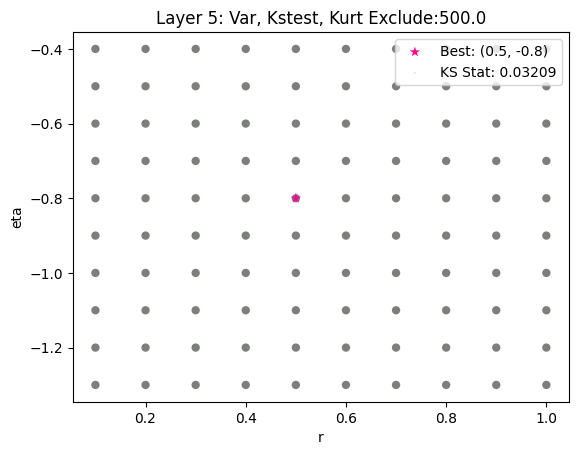

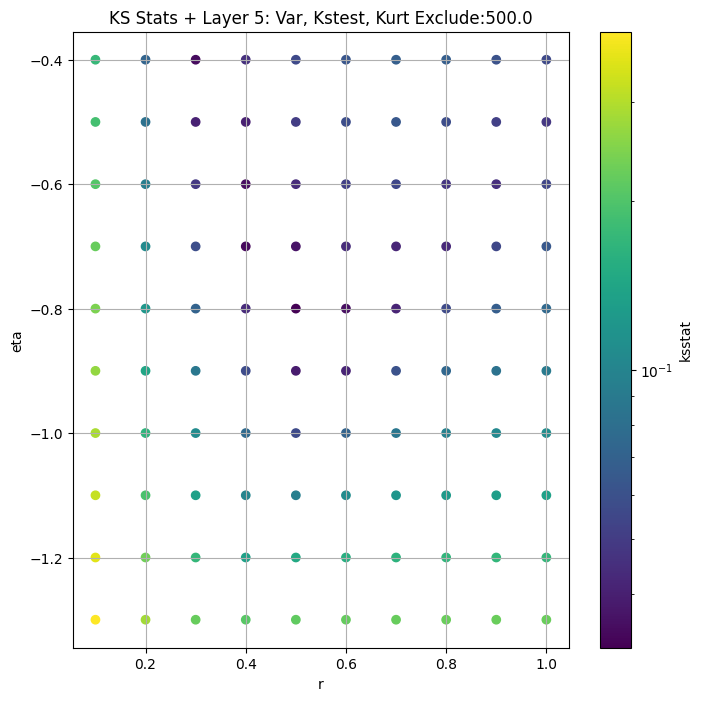

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.03164009477325236 41175.625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.031227222444140834 40109.773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.031137280652106136 39278.81


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.031055625558738753 38544.96


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.030979213195699296 37875.37


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.031001848318080505 36688.703


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.0314482436141007 35646.867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.03186634463281579 34706.965


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.03201968394212423 33845.246


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.031950588717813755 33048.227


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.03160415793527016 30954.287
Number of samples: 100000, Without approximation : 410624


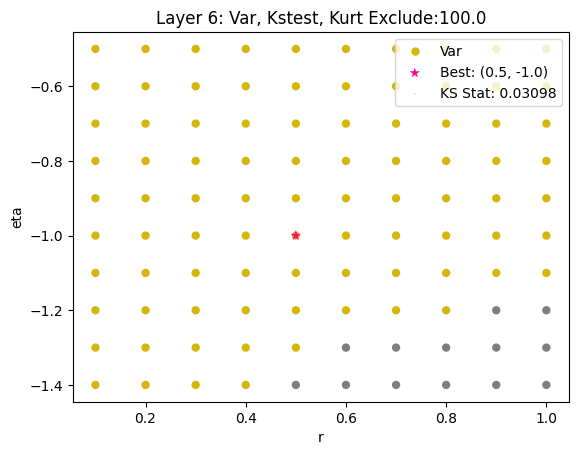

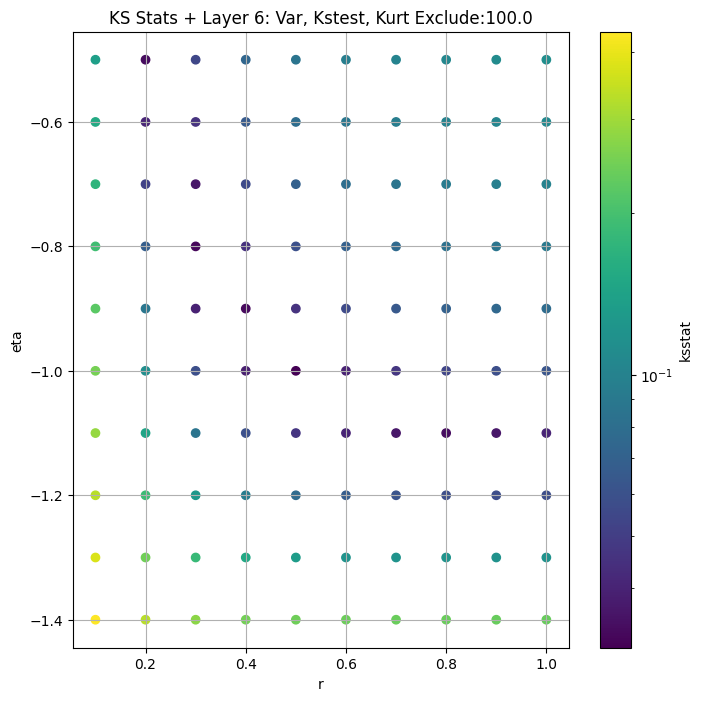

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.0332924033095352 7078.7354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.03403065421671583 6824.425


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.032487639159153536 6636.746


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.03198760035049131 6475.491


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.032715501152926985 6331.187


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.03208932709330212 6078.205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.031991247810540746 5860.1094


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.031811548787639726 5665.756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.031565253513808456 5489.3154


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.03143789490680923 5327.464


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.031421835736564235 4907.4297
Number of samples: 100000, Without approximation : 1642496


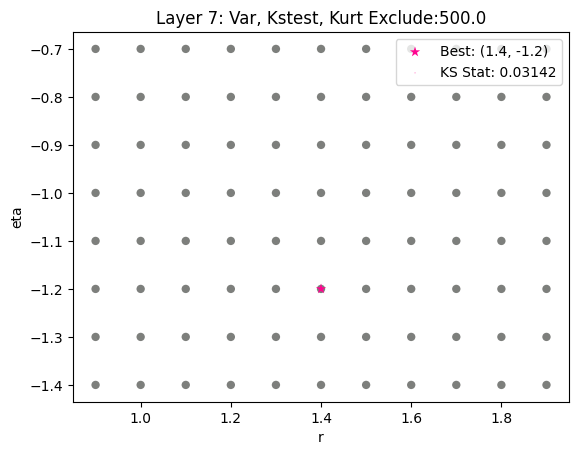

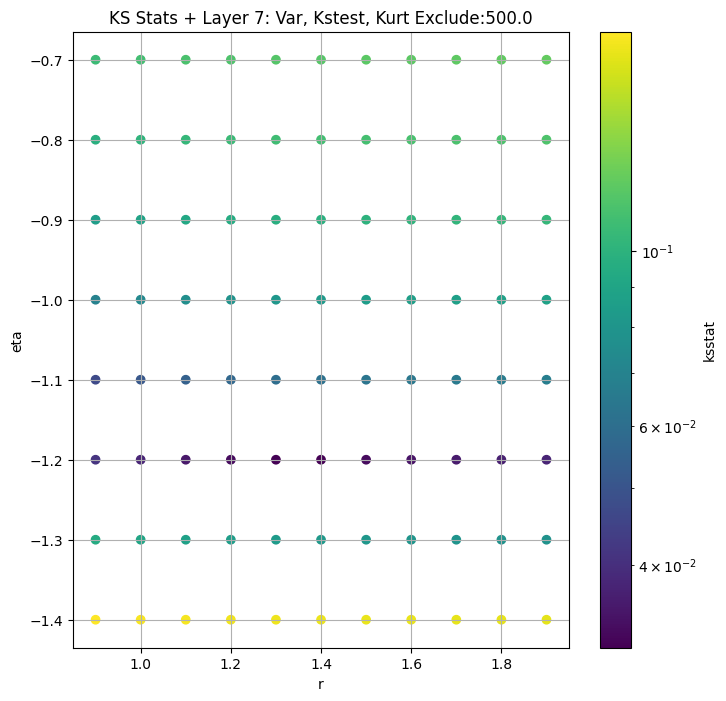

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.016798385530654714 1293.5701


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.0181857369000904 1229.1483


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.018154919215070286 1183.5264


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.017657065309639564 1145.2909


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.017202180063132455 1111.8145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.016377532745428913 1054.4496


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.01665457553586691 1005.88055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.01784076055222894 963.4747


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.0172018842403876 925.6982


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.01662972797853013 891.6469


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.015085364910583487 805.734
Number of samples: 100000, Without approximation : 6569984


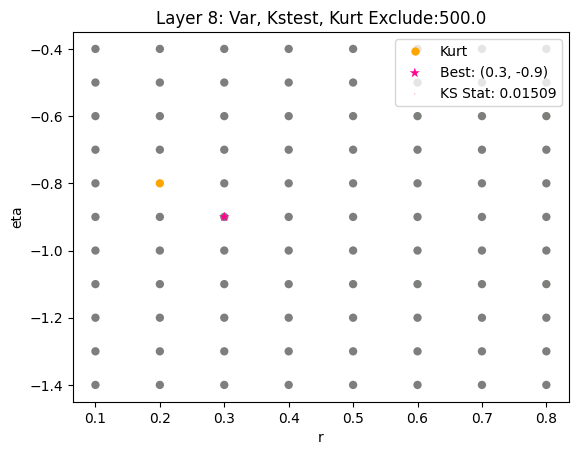

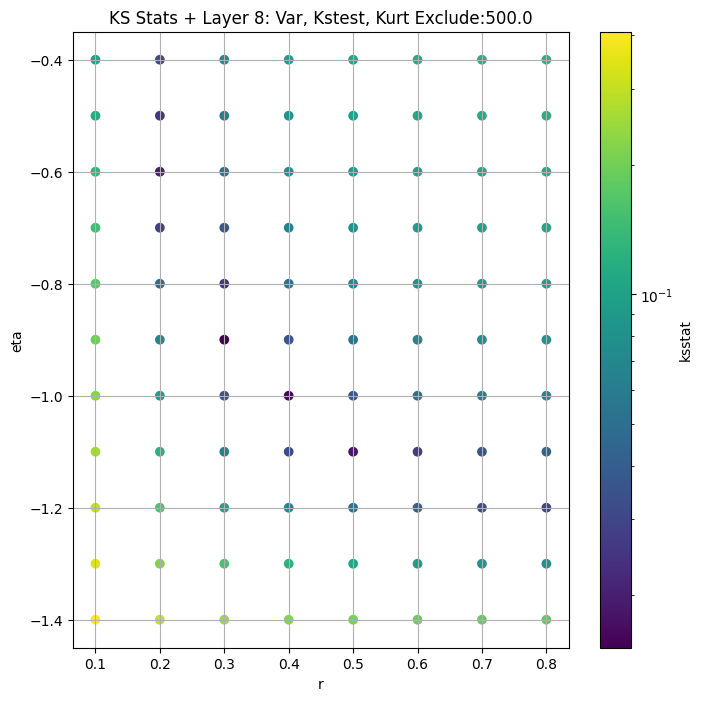

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.011894372634480732 271.75616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.012757715559783112 254.91226


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.013357743602332328 243.33461


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.013941865526871489 233.74208


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.014036039471828077 225.44144


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.013443205510133893 211.42732


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.011591925546996451 199.77402


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.010569892736593256 189.76901


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.01249137884657836 181.00491


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.01446854845833212 173.21228


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.012153776767042379 153.97946
Number of samples: 100000, Without approximation : 26279936


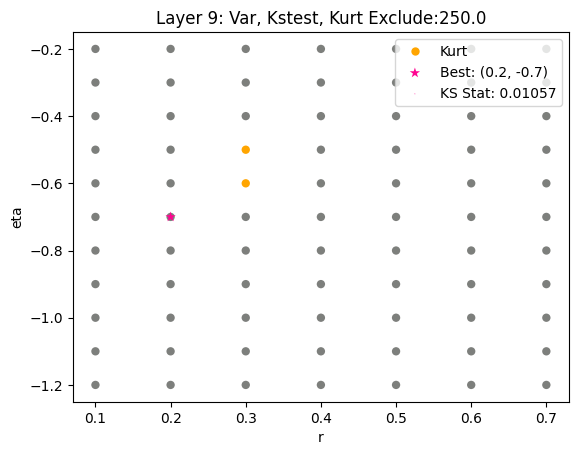

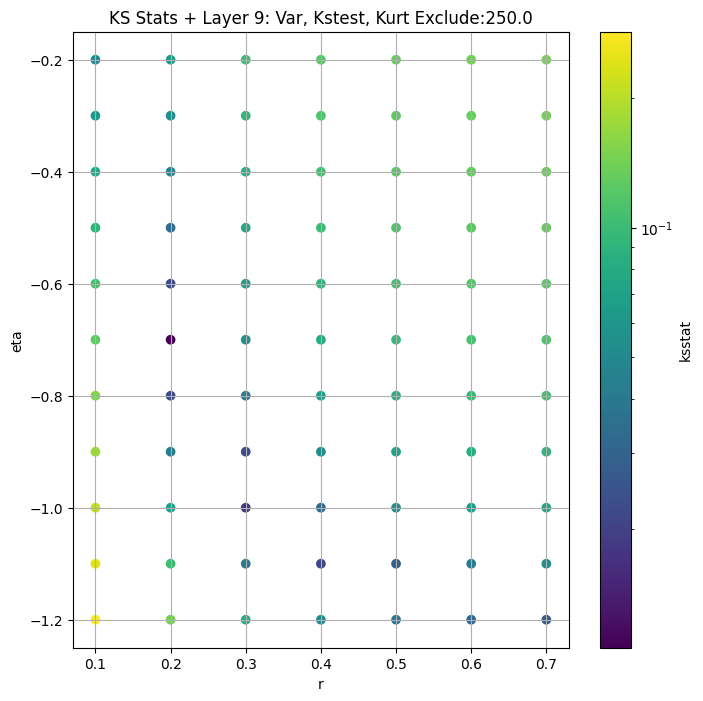

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.674777e+07  2.408478e+07  2.952804e+07   0.489990    0.057459   
3      5.682067e+06  5.344561e+06  6.025917e+06   1.473783    1.142481   
4      1.214204e+06  1.143547e+06  1.286625e+06   3.190731    2.697830   
5      2.286304e+05  2.133339e+05  2.444792e+05   5.111354    4.417289   
6      4.117562e+04  3.780443e+04  4.468856e+04   8.670665    7.367621   
7      7.078735e+03  6.389601e+03  7.818102e+03  13.188631   10.900856   
8      1.293570e+03  1.142861e+03  1.458887e+03  20.103813   15.939114   
9      2.717562e+02  2.358089e+02  3.111081e+02  27.190210   20.843605   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.969847           1604             0.089599        0.6         20.0   
3        1.844055           6416             0.054609        0.4          1.3   
4        3.727371          25664             0.043251        0.4         -0.3   
5        5.861666         102656             0.032089        0.5         -0.8   
6       10.148466         410624             0.030979        0.5         -1.0   
7       15.908423        1642496             0.031422        1.4         -1.2   
8       25.115570        6569984             0.015085        0.3         -0.9   
9       35.941853       26279936             0.010570        0.2         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       67631.309782                     0.0        2.674777e+07   
3       31025.625745                    25.0        5.140449e+06   
4       42705.533497                    50.0        1.117663e+06   
5       55125.227865                   500.0        1.852208e+05   
6       18937.685547                   100.0        3.787537e+04   
7       20010.183410                   500.0        4.907430e+03   
8          20.078619                   500.0        8.057340e+02   
9           0.028239                   250.0        1.897690e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.12560432940178679, var: 14284661.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.11236024217182794, var: 16166225.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.0997285374498097, var: 18432128.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.09190449762004815, var: 21369376.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.089573148160554, var: 26747772.0
Number of samples: 1604, Without approximation : 1604


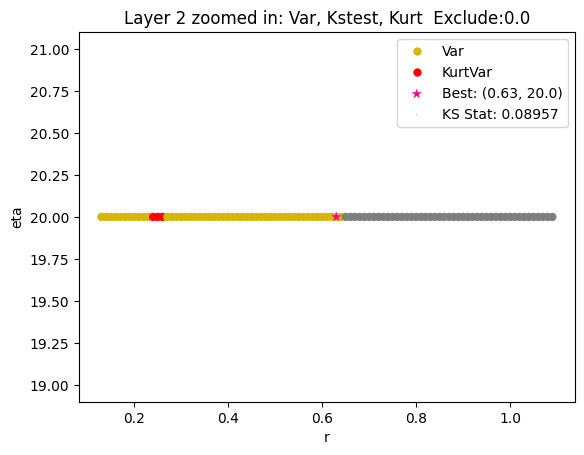

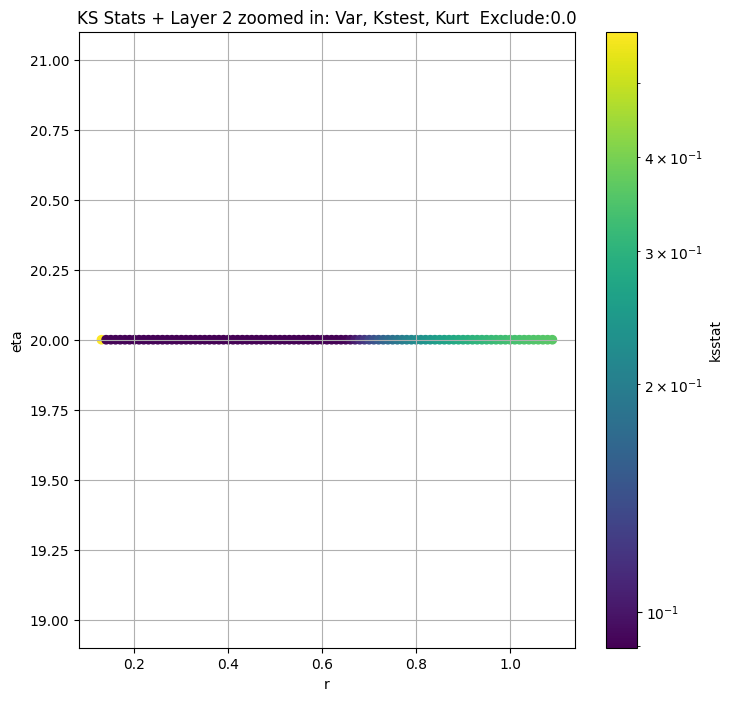

Layer 3


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 25.0 + 100 = 125, ksstat: 0.05573884737791235, var: 4029771.25


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 25.0 + 75 = 100, ksstat: 0.054617962427543465, var: 4248130.5


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 25.0 + 50 = 75, ksstat: 0.05461984452166446, var: 4494450.0


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 25.0 + 25 = 50, ksstat: 0.05459905036979795, var: 4784766.0


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 25.0 + 0 = 25, ksstat: 0.0545972447167713, var: 5140449.0


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 25.0 + -25 = 0, ksstat: 0.054557921214114624, var: 5682067.0
Number of samples: 6416, Without approximation : 6416


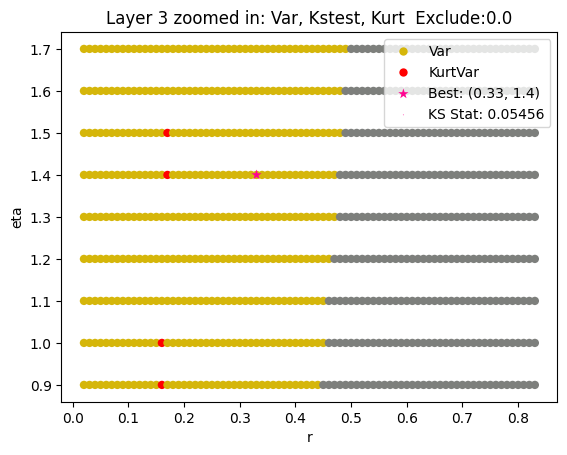

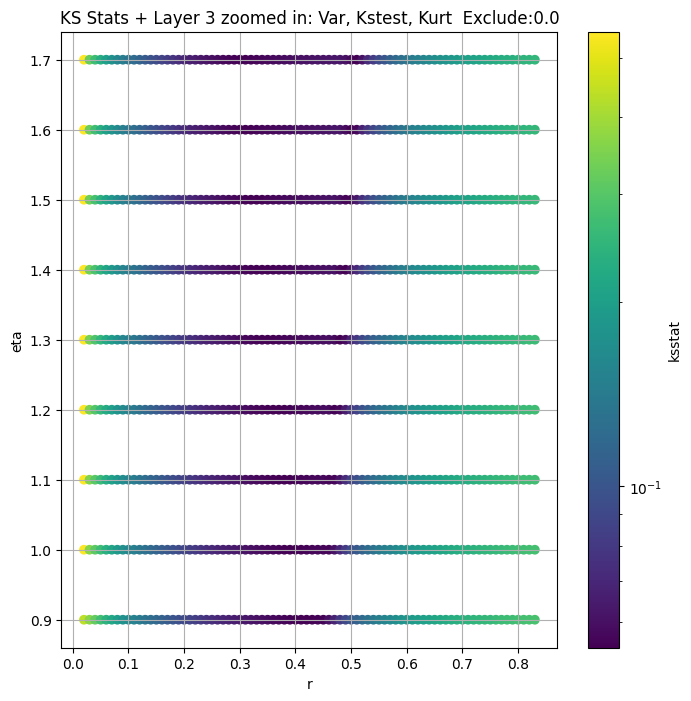

Layer 4


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + 100 = 150, ksstat: 0.04364649914539642, var: 1003741.0625


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + 75 = 125, ksstat: 0.04341728063077949, var: 1028242.4375


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + 50 = 100, ksstat: 0.04339997313107952, var: 1054575.125


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + 25 = 75, ksstat: 0.0433642841583225, var: 1083698.125


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + 0 = 50, ksstat: 0.04308379200357082, var: 1117663.125


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + -25 = 25, ksstat: 0.04309746237575357, var: 1157989.0


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + -50 = 0, ksstat: 0.042939639702524124, var: 1214204.25
Number of samples: 25664, Without approximation : 25664


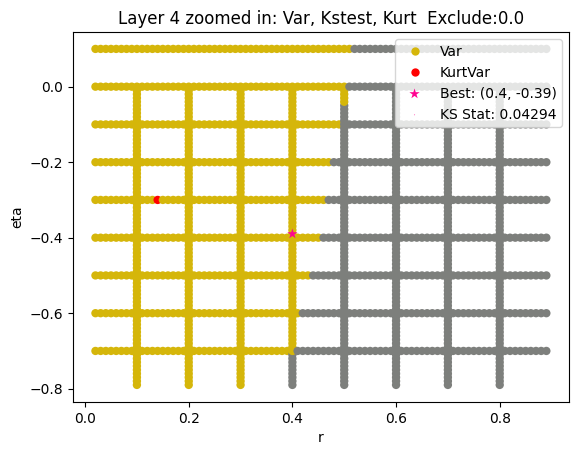

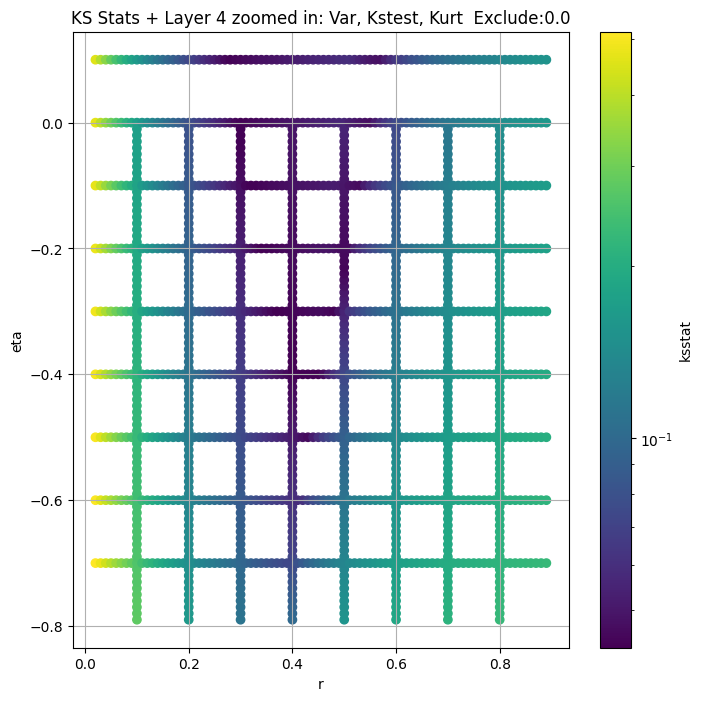

Layer 5


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + 100 = 600, ksstat: 0.031915121885177866, var: 179547.75


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + 75 = 575, ksstat: 0.031915121885177866, var: 180922.3125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + 50 = 550, ksstat: 0.031915121885177866, var: 182325.109375


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + 25 = 525, ksstat: 0.031915121885177866, var: 183758.125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + 0 = 500, ksstat: 0.031915121885177866, var: 185220.765625


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + -25 = 475, ksstat: 0.031915121885177866, var: 186709.828125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + -50 = 450, ksstat: 0.031915121885177866, var: 188233.8125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + -75 = 425, ksstat: 0.031915121885177866, var: 189799.28125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + -100 = 400, ksstat: 0.031902517291307664, var: 191409.171875
Number of samples: 100000, Without approximation : 102656


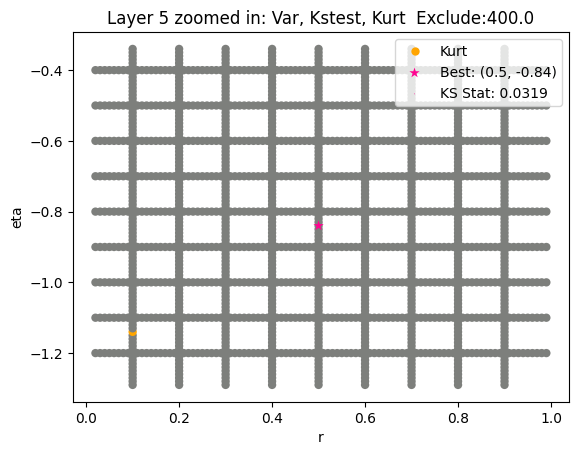

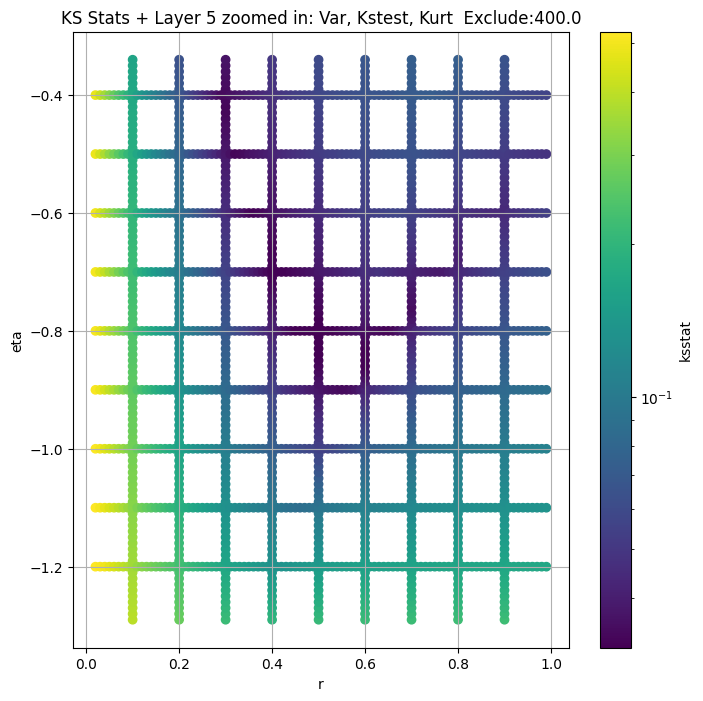

Layer 6


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 100.0 + 100 = 200, ksstat: 0.030729018227076854, var: 35646.8671875


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 100.0 + 75 = 175, ksstat: 0.030956926067649937, var: 36152.76953125


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 100.0 + 50 = 150, ksstat: 0.031001848318080505, var: 36688.703125


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 100.0 + 25 = 125, ksstat: 0.030907355783301338, var: 37260.359375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 100.0 + 0 = 100, ksstat: 0.030979213195699296, var: 37875.37109375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 100.0 + -25 = 75, ksstat: 0.03086921834215639, var: 38544.9609375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 100.0 + -50 = 50, ksstat: 0.030952313810295617, var: 39278.80859375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 100.0 + -75 = 25, ksstat: 0.030870061224742673, var: 40109.7734375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 100.0 + -100 = 0, ksstat: 0.030847875594039453, var: 41175.625
Number of samples: 100000, Without approximation : 410624


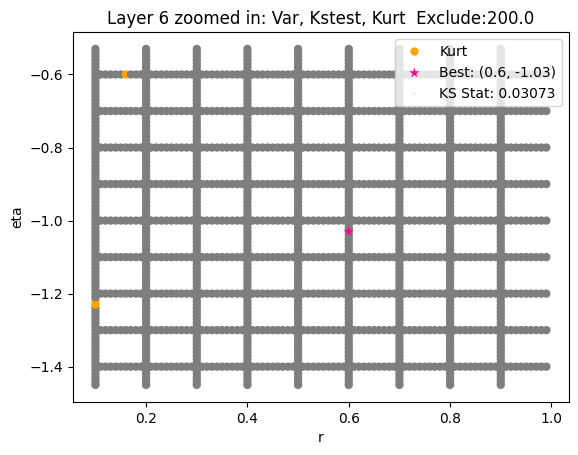

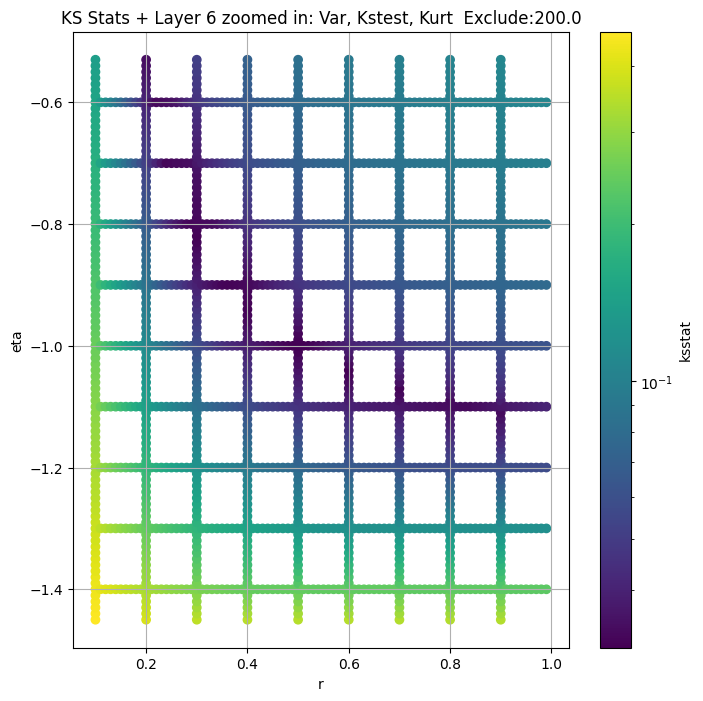

Layer 7


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 500.0 + 100 = 600, ksstat: 0.029691916780303085, var: 4668.47900390625


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 500.0 + 75 = 575, ksstat: 0.029819750661902122, var: 4725.63623046875


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 500.0 + 50 = 550, ksstat: 0.0299491988942025, var: 4784.42578125


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 500.0 + 25 = 525, ksstat: 0.029743300700060704, var: 4845.02001953125


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 500.0 + 0 = 500, ksstat: 0.03028854156133992, var: 4907.4296875


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 500.0 + -25 = 475, ksstat: 0.029864559557085668, var: 4971.70947265625


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 500.0 + -50 = 450, ksstat: 0.02960365082787697, var: 5038.10888671875


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 500.0 + -75 = 425, ksstat: 0.02974559276372274, var: 5106.74462890625


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 500.0 + -100 = 400, ksstat: 0.030094311314877303, var: 5177.72509765625
Number of samples: 100000, Without approximation : 1642496


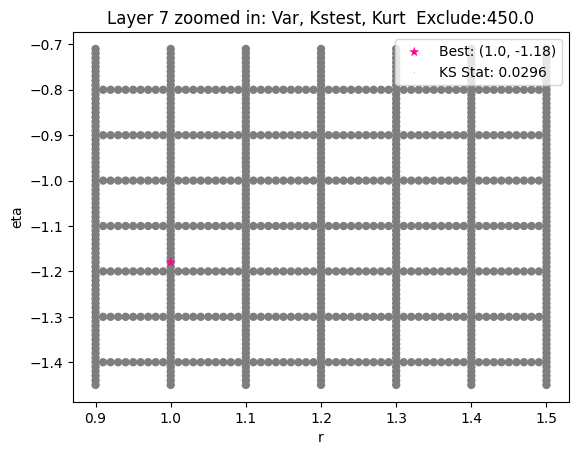

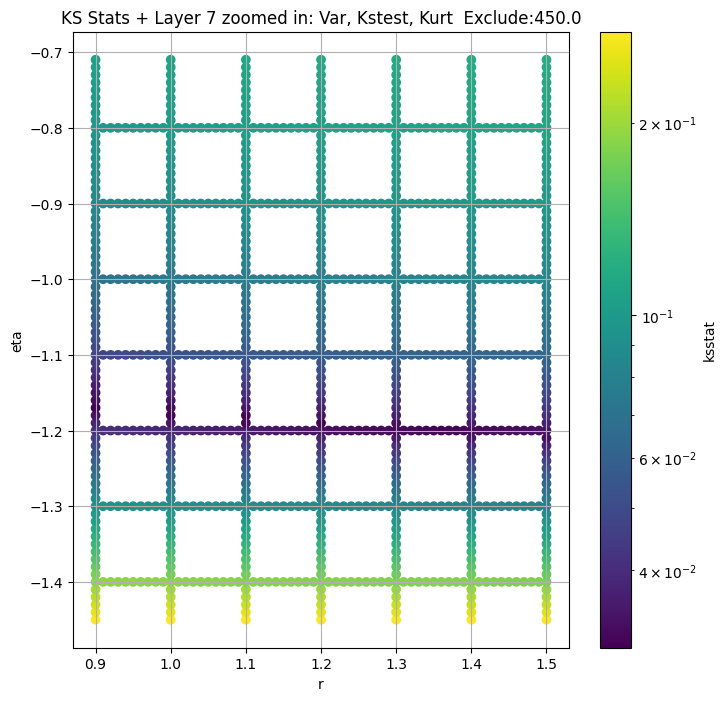

Layer 8


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 500.0 + 100 = 600, ksstat: 0.013373273599064872, var: 758.3128662109375


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 500.0 + 75 = 575, ksstat: 0.013560785000850062, var: 769.5725708007812


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 500.0 + 50 = 550, ksstat: 0.013337367229192376, var: 781.2147216796875


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 500.0 + 25 = 525, ksstat: 0.013361658048802905, var: 793.2597045898438


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 500.0 + 0 = 500, ksstat: 0.013599990160829523, var: 805.7340087890625


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 500.0 + -25 = 475, ksstat: 0.013573731682691215, var: 818.6747436523438


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 500.0 + -50 = 450, ksstat: 0.013394305462342493, var: 832.1143798828125


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 500.0 + -75 = 425, ksstat: 0.0133275602286686, var: 846.089599609375


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 500.0 + -100 = 400, ksstat: 0.013540182154976321, var: 860.6312866210938
Number of samples: 100000, Without approximation : 6569984


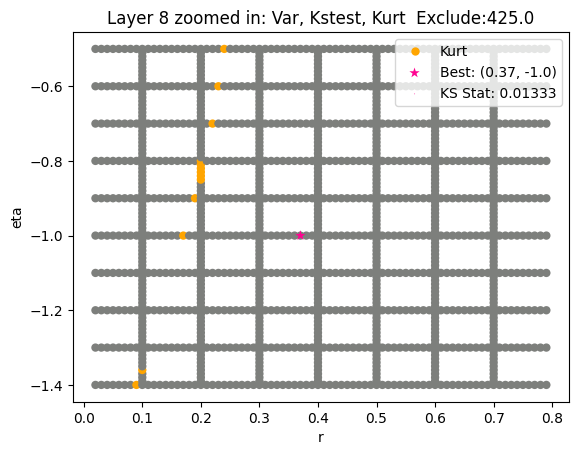

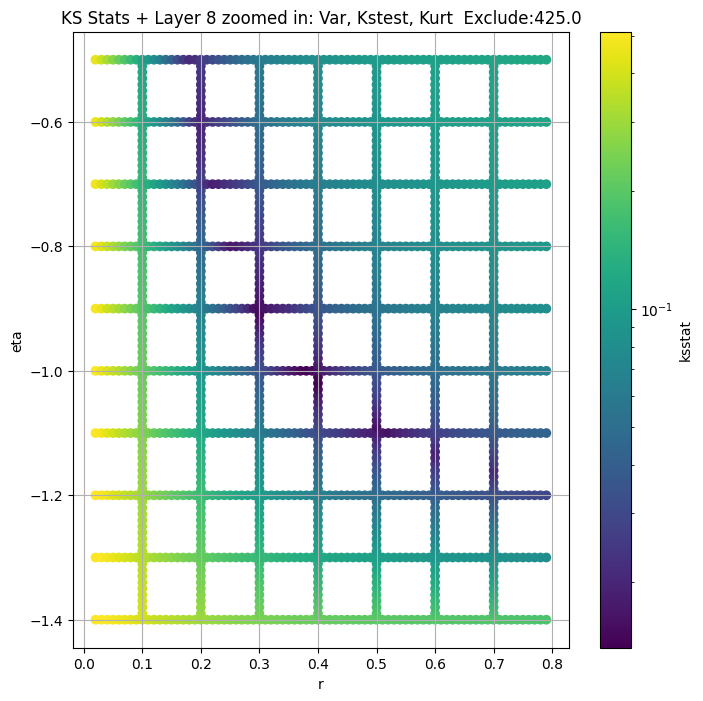

Layer 9


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 250.0 + 100 = 350, ksstat: 0.011073214517310803, var: 173.2122802734375


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 250.0 + 75 = 325, ksstat: 0.011123396476784175, var: 177.00057983398438


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 250.0 + 50 = 300, ksstat: 0.010595798783900379, var: 181.00491333007812


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 250.0 + 25 = 275, ksstat: 0.01035709907323934, var: 185.25135803222656


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 250.0 + 0 = 250, ksstat: 0.010111924431336017, var: 189.76901245117188


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 250.0 + -25 = 225, ksstat: 0.01000813962441749, var: 194.59500122070312


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 250.0 + -50 = 200, ksstat: 0.009898001657137945, var: 199.77401733398438


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 250.0 + -75 = 175, ksstat: 0.009825705725003242, var: 205.3607635498047


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 250.0 + -100 = 150, ksstat: 0.009918554586994532, var: 211.4273223876953
Number of samples: 100000, Without approximation : 26279936


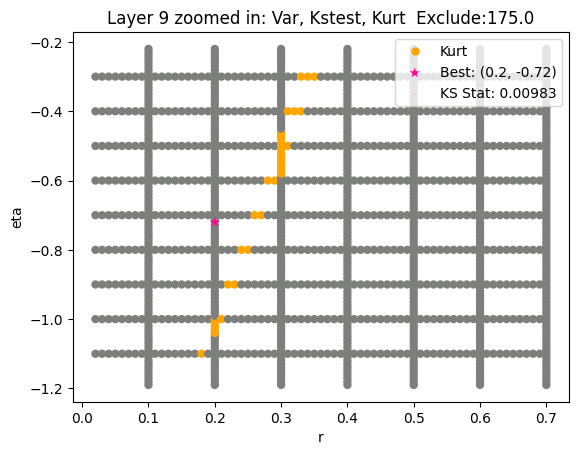

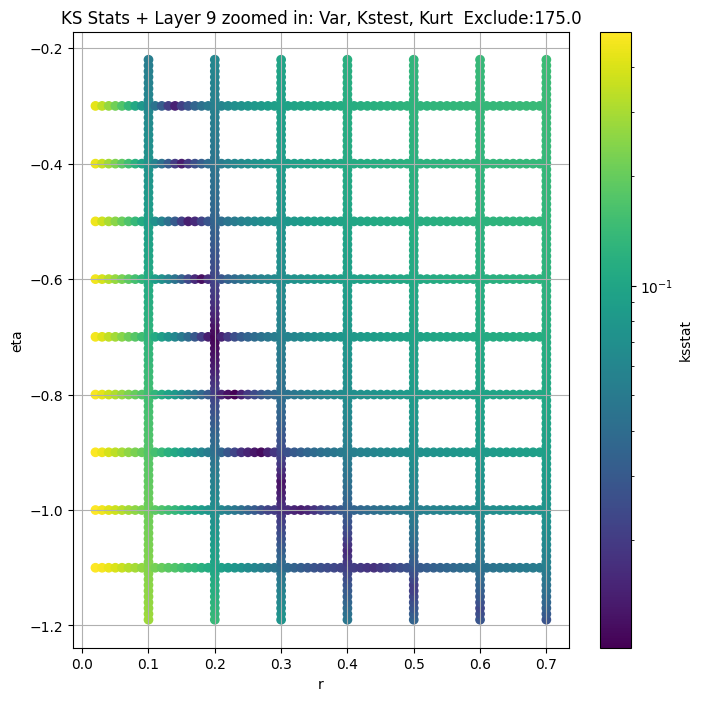

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.674777e+07  2.408478e+07  2.952804e+07   0.489990    0.057459   
3      5.682067e+06  5.344561e+06  6.025917e+06   1.473783    1.142481   
4      1.214204e+06  1.143547e+06  1.286625e+06   3.190731    2.697830   
5      2.286304e+05  2.133339e+05  2.444792e+05   5.111354    4.417289   
6      4.117562e+04  3.780443e+04  4.468856e+04   8.670665    7.367621   
7      7.078735e+03  6.389601e+03  7.818102e+03  13.188631   10.900856   
8      1.293570e+03  1.142861e+03  1.458887e+03  20.103813   15.939114   
9      2.717562e+02  2.358089e+02  3.111081e+02  27.190210   20.843605   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.969847           1604             0.089599        0.6         20.0   
3        1.844055           6416             0.054609        0.4          1.3   
4        3.727371          25664             0.043251        0.4         -0.3   
5        5.861666         102656             0.032089        0.5         -0.8   
6       10.148466         410624             0.030979        0.5         -1.0   
7       15.908423        1642496             0.031422        1.4         -1.2   
8       25.115570        6569984             0.015085        0.3         -0.9   
9       35.941853       26279936             0.010570        0.2         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       67631.309782                     0.0        2.674777e+07   
3       31025.625745                    25.0        5.682067e+06   
4       42705.533497                    50.0        1.214204e+06   
5       55125.227865                   500.0        1.914092e+05   
6       18937.685547                   100.0        3.564687e+04   
7       20010.183410                   500.0        5.038109e+03   
8          20.078619                   500.0        8.460896e+02   
9           0.028239                   250.0        2.053608e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.089573    0.63     20.00   
3                     0.016929          0.054558    0.33      1.40   
4                     0.008471          0.042940    0.40     -0.39   
5                     0.004237          0.031903    0.50     -0.84   
6                     0.002119          0.030729    0.60     -1.03   
7                     0.001060          0.029604    1.00     -1.18   
8                     0.000530          0.013328    0.37     -1.00   
9                     0.000265          0.009826    0.20     -0.72   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      97258.912389                  0.0          225  
3       5689.555953                  0.0          601  
4      54446.951877                  0.0         1012  
5      62502.994996                400.0         1804  
6      32851.069282                200.0         2029  
7      15744.090271                450.0         2029  
8        117.350023                425.0        10827  
9          0.033414                175.0        19248

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

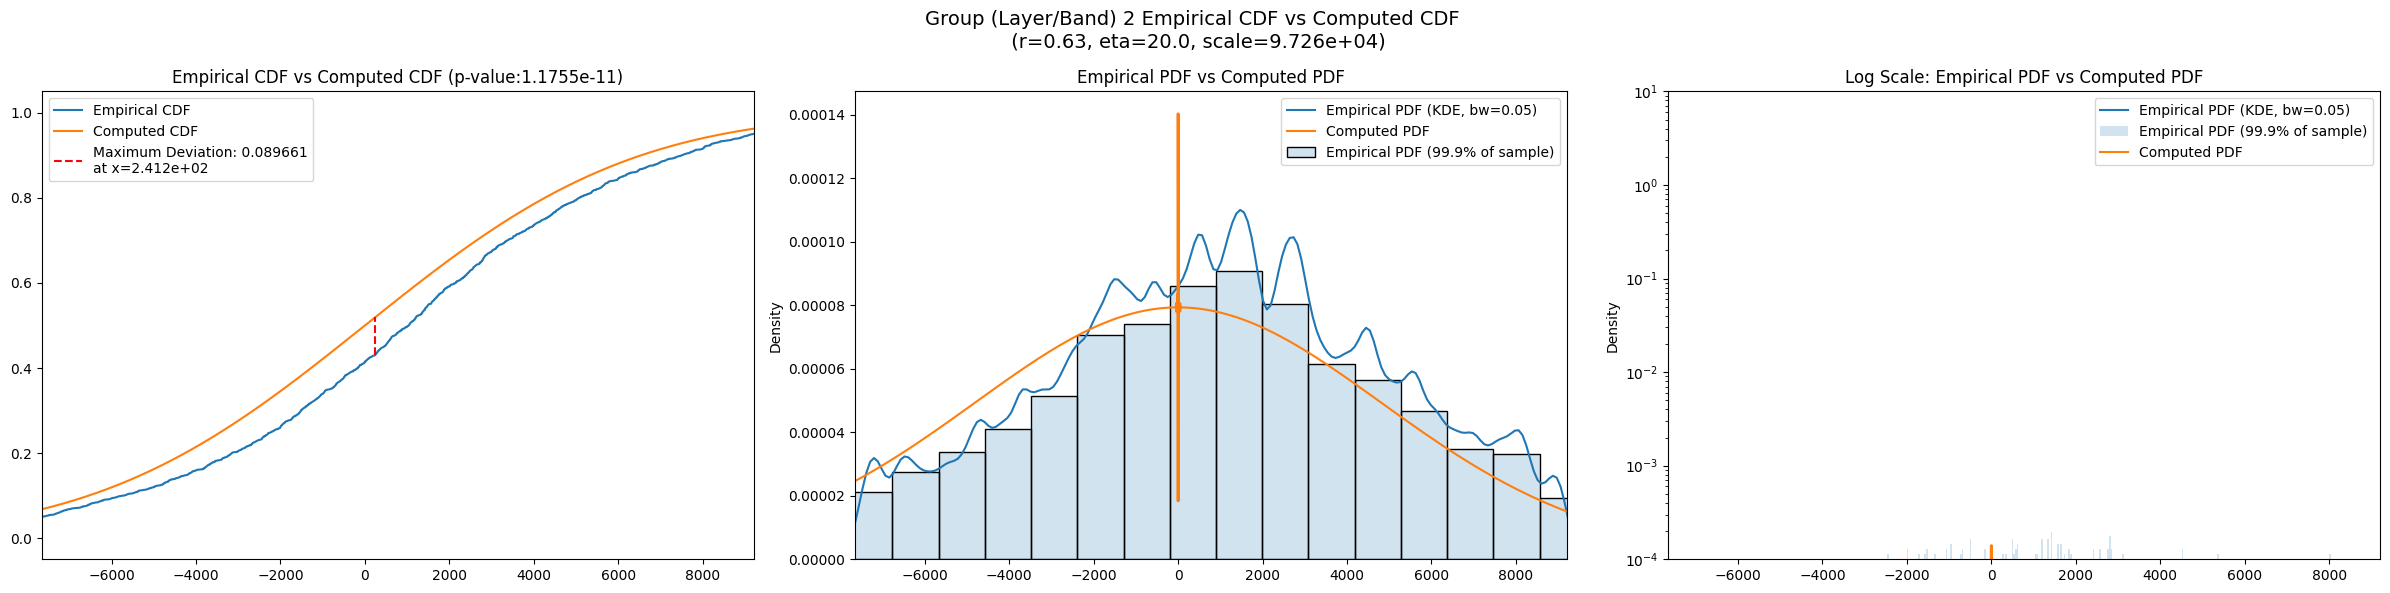

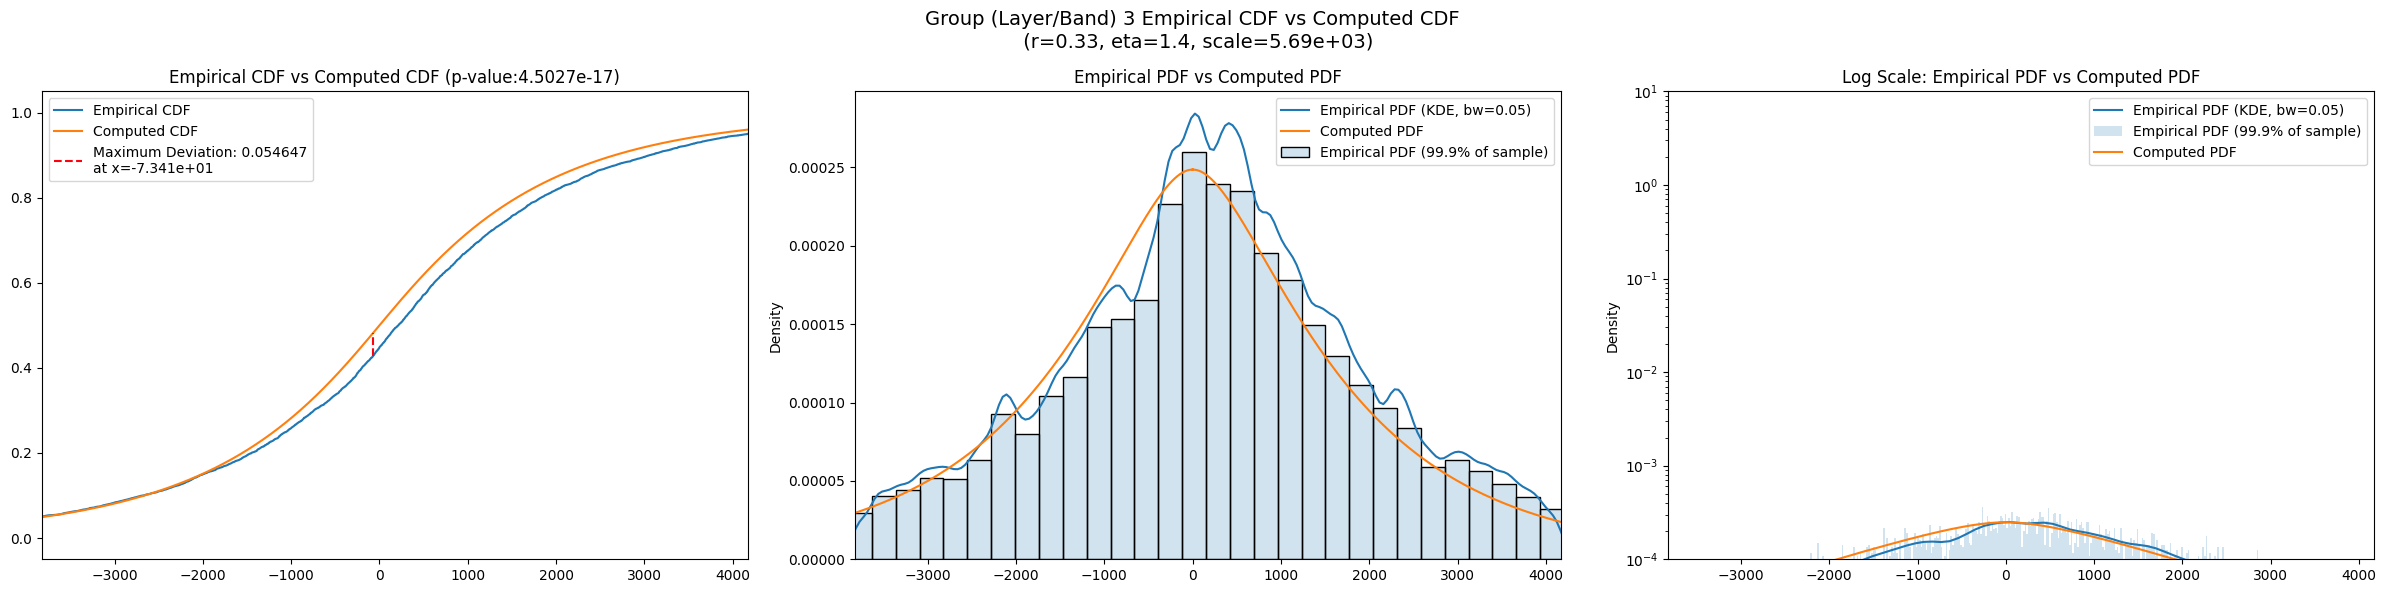

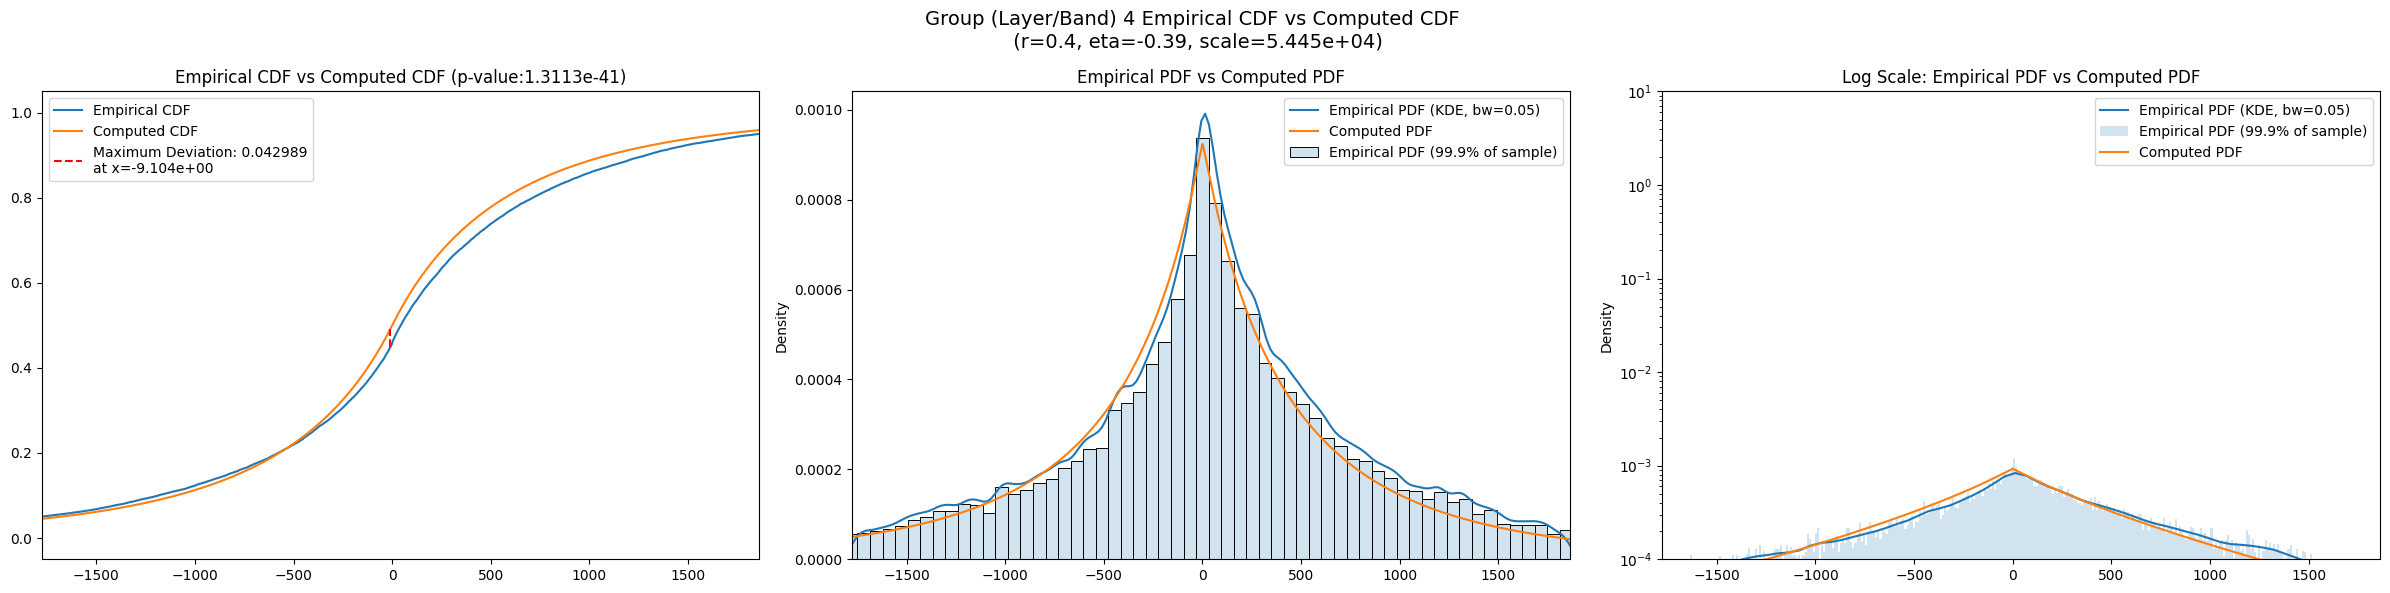

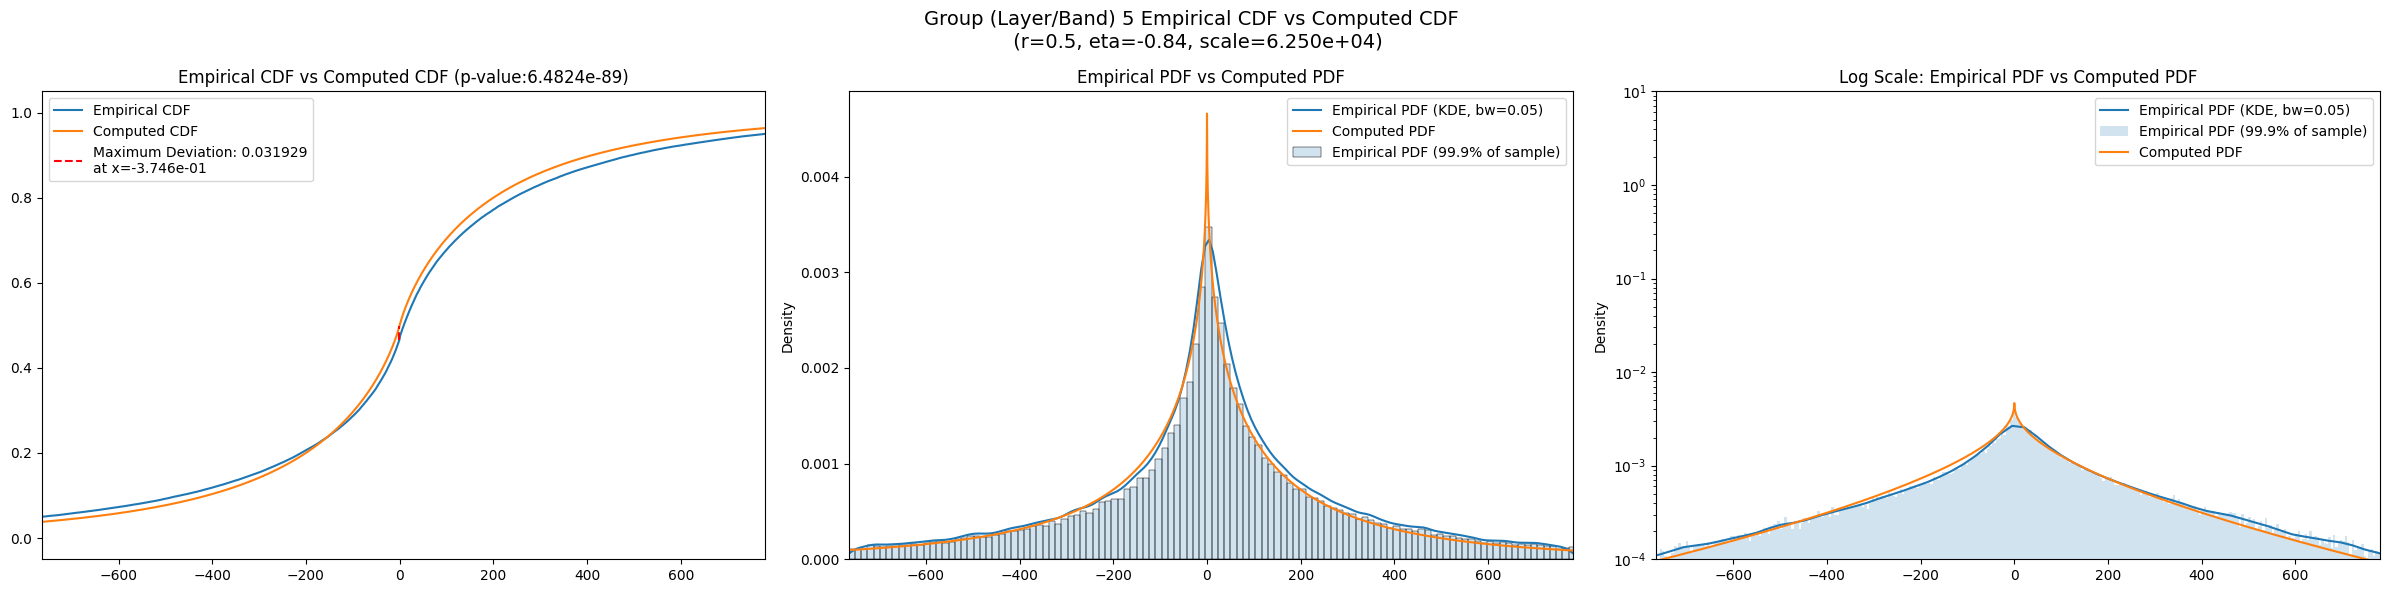

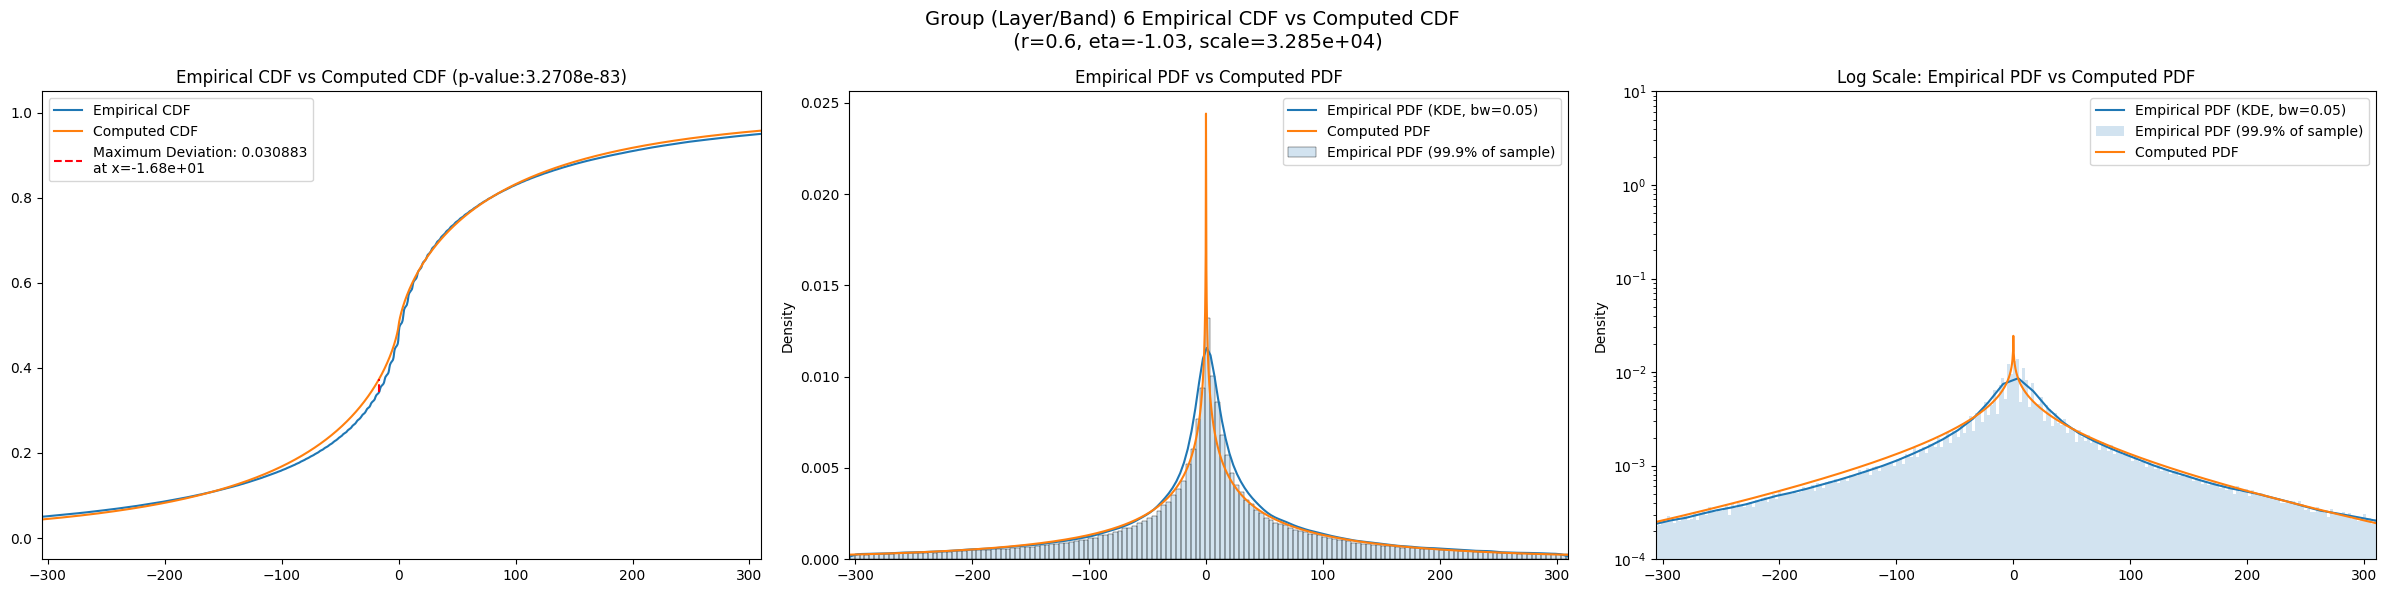

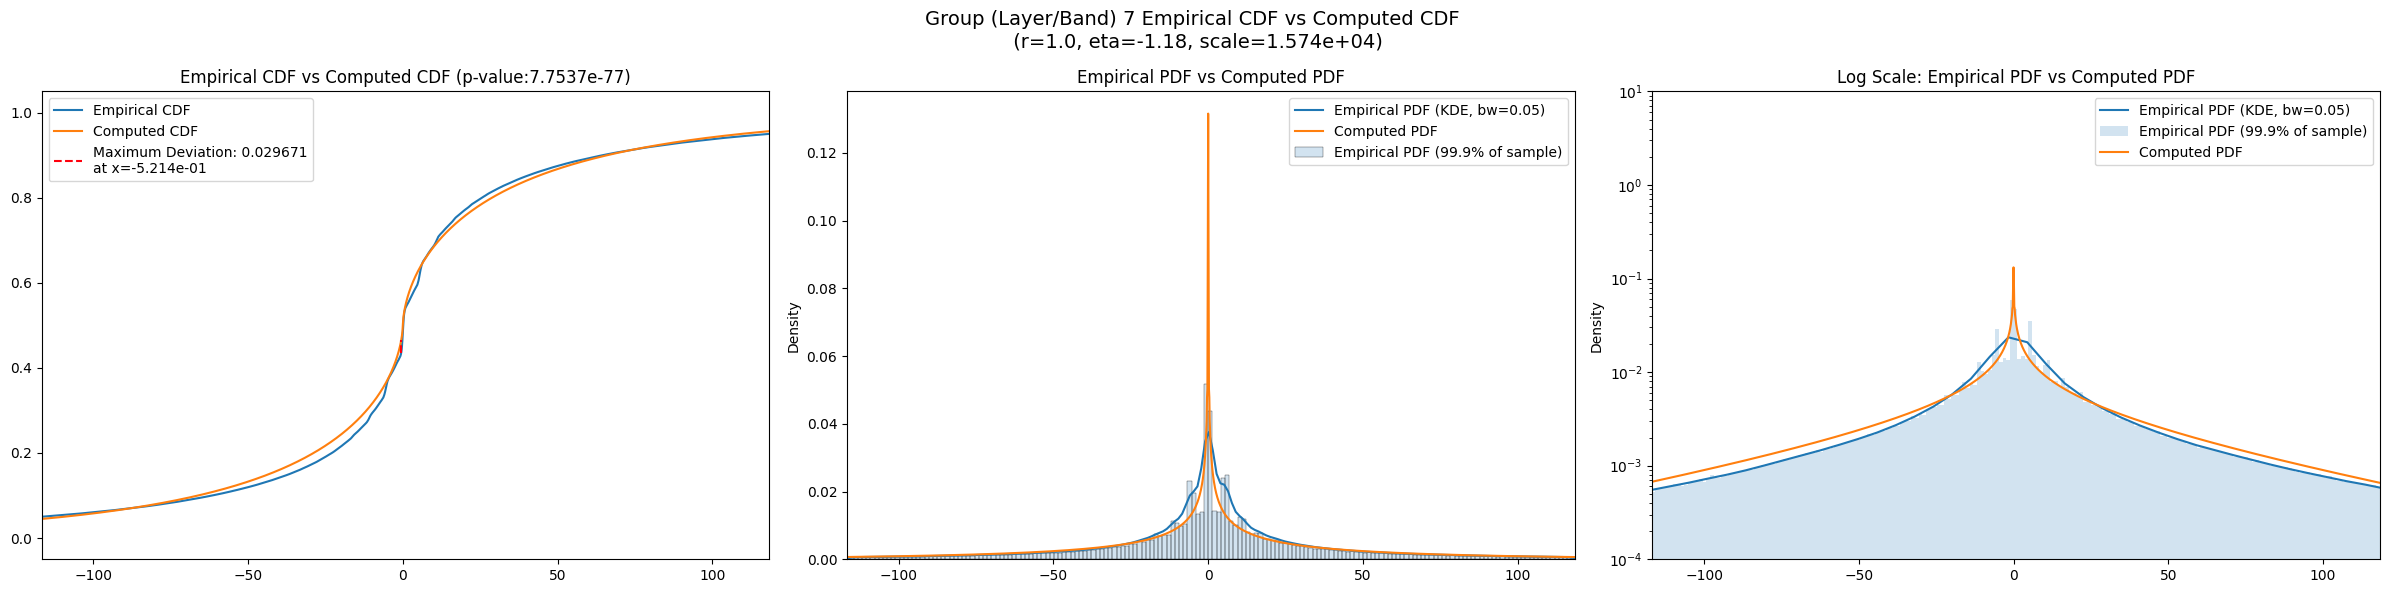

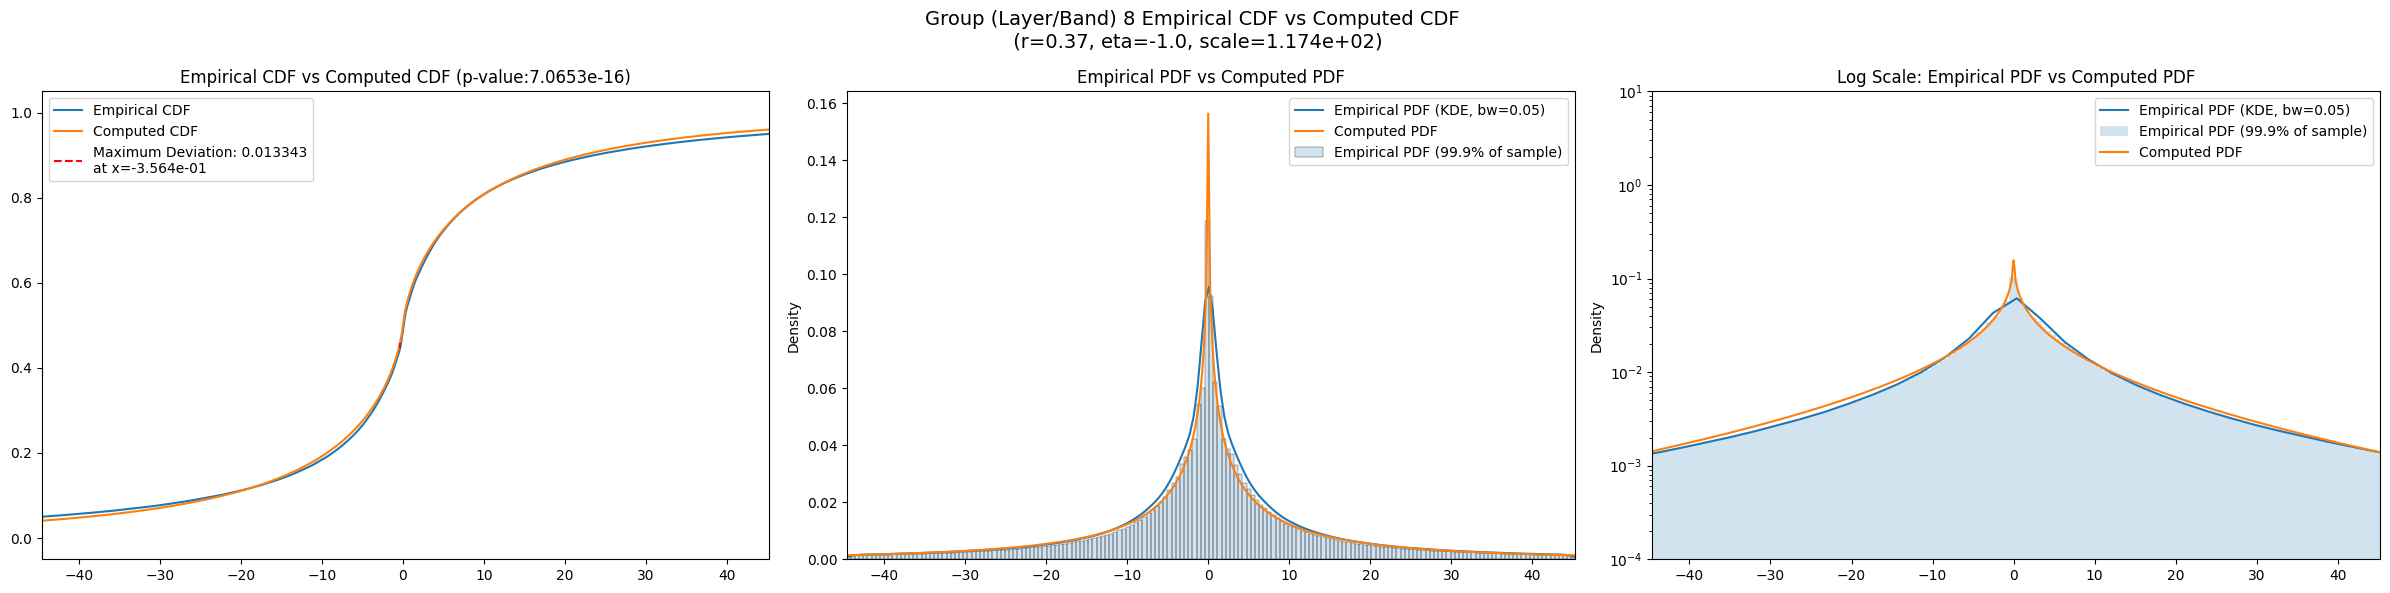

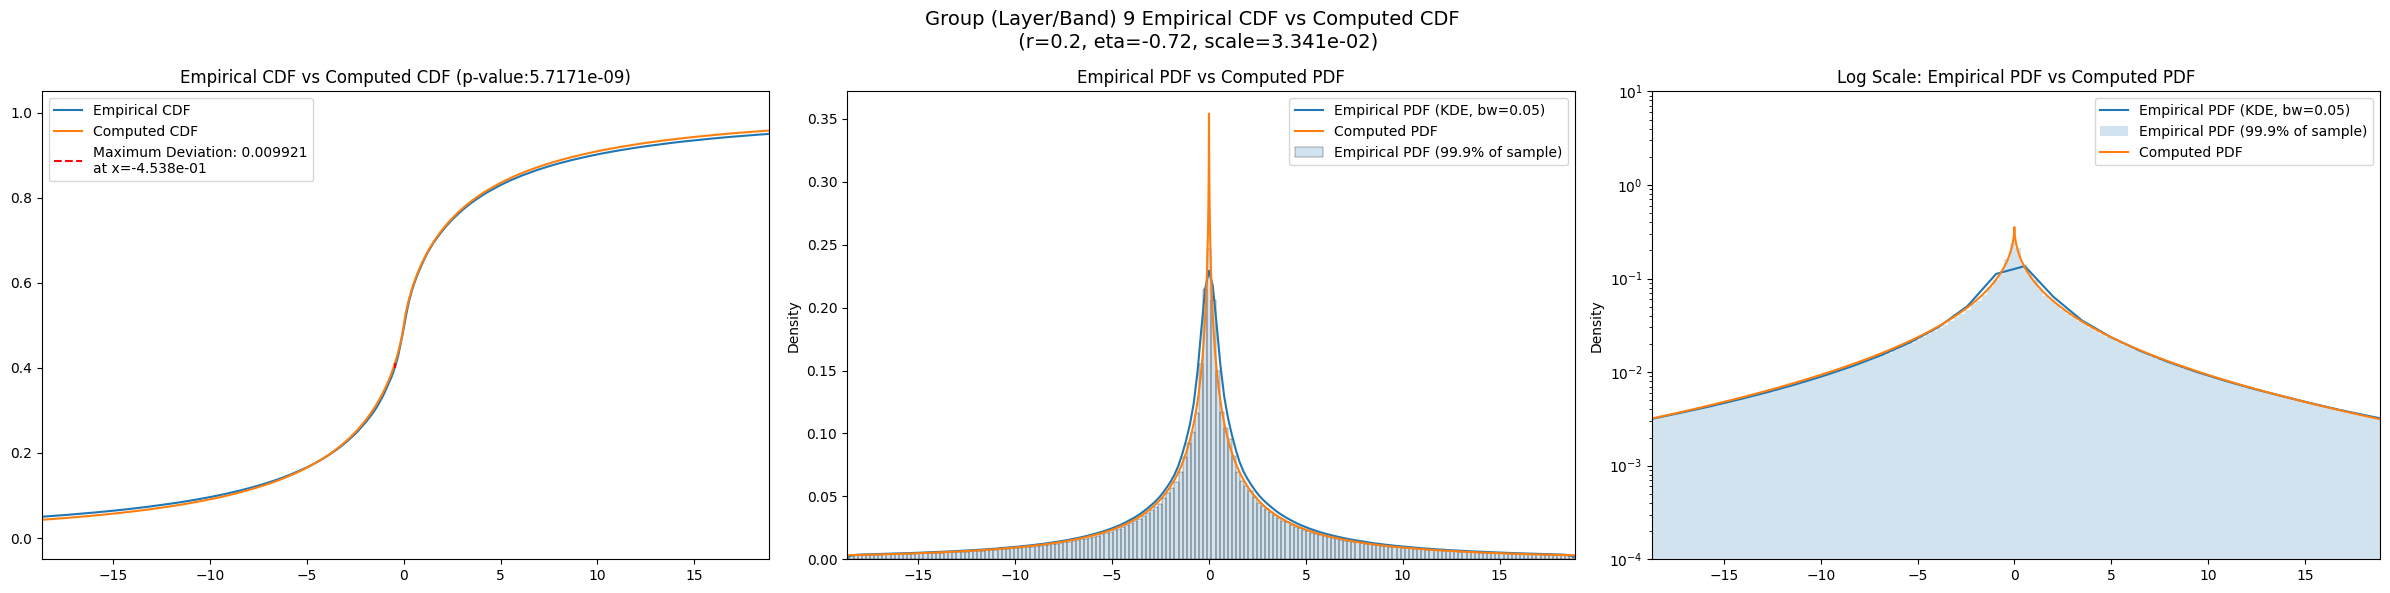

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.674777e+07  2.408478e+07  2.952804e+07   0.489990    0.057459   
3      5.682067e+06  5.344561e+06  6.025917e+06   1.473783    1.142481   
4      1.214204e+06  1.143547e+06  1.286625e+06   3.190731    2.697830   
5      2.286304e+05  2.133339e+05  2.444792e+05   5.111354    4.417289   
6      4.117562e+04  3.780443e+04  4.468856e+04   8.670665    7.367621   
7      7.078735e+03  6.389601e+03  7.818102e+03  13.188631   10.900856   
8      1.293570e+03  1.142861e+03  1.458887e+03  20.103813   15.939114   
9      2.717562e+02  2.358089e+02  3.111081e+02  27.190210   20.843605   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.969847           1604             0.089599        0.6         20.0   
3        1.844055           6416             0.054609        0.4          1.3   
4        3.727371          25664             0.043251        0.4         -0.3   
5        5.861666         102656             0.032089        0.5         -0.8   
6       10.148466         410624             0.030979        0.5         -1.0   
7       15.908423        1642496             0.031422        1.4         -1.2   
8       25.115570        6569984             0.015085        0.3         -0.9   
9       35.941853       26279936             0.010570        0.2         -0.7   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      5146.86000              0.089138          1.538420e-11   
3      ...      1784.49000              0.059655          2.730110e-20   
4      ...       726.25200              0.063804          2.841770e-91   
5      ...       260.43900              0.071942          0.000000e+00   
6      ...        87.91430              0.081734          0.000000e+00   
7      ...        29.76290              0.085935          0.000000e+00   
8      ...        11.78740              0.078413          0.000000e+00   
9      ...         4.83055              0.079535          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         5633.23000             0.091406         4.111280e-12  4468.40000   
3         1918.12000             0.054094         9.287370e-17  1427.10000   
4          613.42100             0.045206         5.168550e-46   517.88400   
5          221.96000             0.047623        9.231780e-203   179.93300   
6           74.49710             0.057377         0.000000e+00    58.73260   
7           25.61480             0.060584         0.000000e+00    20.02410   
8           10.27570             0.052989         0.000000e+00     7.83561   
9            4.21422             0.053883         0.000000e+00     3.24474   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.089520   1.234970e-11          1.197588e-11  
3           0.054611   4.512160e-17          4.861774e-17  
4           0.049698   1.579290e-55          1.481836e-41  
5           0.052337  7.852030e-245          3.319327e-91  
6           0.060154   0.000000e+00          0.000000e+00  
7           0.060998   0.000000e+00          0.000000e+00  
8           0.053614   0.000000e+00          0.000000e+00  
9           0.054001   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.089599                 0.033804          0.089573   
3                 0.054609                 0.016929          0.054558   
4                 0.043251                 0.008471          0.042940   
5                 0.032089                 0.004237          0.031903   
6                 0.030979                 0.002119          0.030729   
7                 0.031422                 0.001060          0.029604   
8                 0.015085                 0.000530          0.013328   
9                 0.010570                 0.000265          0.009826   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.089138             0.091406       0.089520  
3                  0.059655             0.054094       0.054611  
4                  0.063804             0.045206       0.049698  
5                  0.071942             0.047623       0.052337  
6                  0.081734             0.057377       0.060154  
7                  0.085935             0.060584       0.060998  
8                  0.078413             0.052989       0.053614  
9                  0.079535             0.053883       0.054001

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            2.674777e+07          0.089573    0.63     20.00  97258.912389   
3            5.682067e+06          0.054558    0.33      1.40   5689.555953   
4            1.214204e+06          0.042940    0.40     -0.39  54446.951877   
5            1.914092e+05          0.031903    0.50     -0.84  62502.994996   
6            3.564687e+04          0.030729    0.60     -1.03  32851.069282   
7            5.038109e+03          0.029604    1.00     -1.18  15744.090271   
8            8.460896e+02          0.013328    0.37     -1.00    117.350023   
9            2.053608e+02          0.009826    0.20     -0.72      0.033414   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                    400.0  
6                    200.0  
7                    450.0  
8                    425.0  
9                    175.0

In [21]:
eng.quit()